In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shared_utils
from matplotlib.ticker import ScalarFormatter
from scipy.stats import zscore
from cpb_analysis_scripts import *



## Initial df aggregates

In [2]:
# initial, overall df
all_bus = pd.read_parquet(
    "gs://calitp-analytics-data/data-analyses/bus_procurement_cost/cpb_analysis_data_merge.parquet"
)

# Variables
total_unique_projects = len(all_bus)
total_bus_count = sum(all_bus.bus_count)
total_funding = sum(all_bus.total_cost)

# initial df with cpb
all_bus_cpb = overall_cpb(all_bus)

# get zscore
cpb_zscore = get_zscore(all_bus_cpb)

# initial df with cpb/zscore, remove outliers
no_outliers = remove_outliers(cpb_zscore, "zscore_cost_per_bus" )

# aggregate by transit agency
agency_agg = cpb_aggregate(all_bus,"transit_agency")

#aggregate by prop type
prop_agg = cpb_aggregate(all_bus,"prop_type")

#aggregate by bus size
size_agg = cpb_aggregate(all_bus,"bus_size_type")

min_bus_cost = cpb_zscore.cpb.min()
max_bus_cost = cpb_zscore.cpb.max()
max_bus_count = cpb_zscore.bus_count.max()

#VARIABLES
cpb_mean = cpb_zscore.cpb.mean()
cpb_std = cpb_zscore.cpb.std()

# agency with highest bus count
agency_with_most_bus = cpb_zscore.loc[cpb_zscore["bus_count"].idxmax(), "transit_agency"]

# propulsion type max count and name
prop_type_name_max_freq = cpb_zscore["prop_type"].value_counts().idxmax()
prop_type_max = cpb_zscore["prop_type"].value_counts().max()

# prop type min count and anme
prop_type_name_min_freq = cpb_zscore["prop_type"].value_counts().idxmin()
prop_type_min = cpb_zscore["prop_type"].value_counts().min()

# how many buses do they have? already answered
agency_with_highest_funds = cpb_zscore.loc[
    all_bus["total_cost"].idxmax(), "transit_agency"
]

# what is the highest amount? already answered
agency_max_cpb = cpb_zscore.loc[cpb_zscore["cpb"].idxmax(), "transit_agency"]
agency_min_cpb = cpb_zscore.loc[cpb_zscore["cpb"].idxmin(), "transit_agency"]
prop_type_max_cpb = cpb_zscore.loc[cpb_zscore["cpb"].idxmax(), "prop_type"]
prop_type_min_cpb = cpb_zscore.loc[cpb_zscore["cpb"].idxmin(), "prop_type"]

## ZEB only df

In [3]:
# zeb only df
zeb_only = zeb_only_df(all_bus)

# calc cpb
zeb_cpb = overall_cpb(zeb_only)

# get zscore
zeb_zscore = get_zscore(zeb_cpb)

# remove outliers
zeb_no_outliers = remove_outliers(zeb_zscore, "zscore_cost_per_bus" )

# aggregate by transit agency
zeb_agency_agg = cpb_aggregate(zeb_only,"transit_agency")

#aggregate by prop type
zeb_prop_agg = cpb_aggregate(zeb_only,"prop_type")

#aggregate by bus size
zeb_size_agg = cpb_aggregate(zeb_only,"bus_size_type")

#VARIABLES
zeb_count = len(zeb_only.prop_type)

# zeb only, no outliers cpb curve
zeb_only_mean = zeb_no_outliers.cpb.mean()
zeb_only_std = zeb_no_outliers.cpb.std()


## Non ZEB only df

In [4]:
#no zeb df
non_zeb_only = non_zeb_only_df(all_bus)

# calc cpb
non_zeb_cpb = overall_cpb(non_zeb_only)

# get zscore
non_zeb_zscore = get_zscore(non_zeb_cpb)

# remove outliers
non_zeb_no_outliers = remove_outliers(non_zeb_zscore, "zscore_cost_per_bus" )

# aggregate by transit agency
non_zeb_agency_agg = cpb_aggregate(non_zeb_only,"transit_agency")

#aggregate by prop type
non_zeb_prop_agg = cpb_aggregate(non_zeb_only,"prop_type")

#aggregate by bus size
non_zeb_size_agg = cpb_aggregate(non_zeb_only,"bus_size_type")

#VARIABLES
non_zeb_count = len(non_zeb_only.prop_type)

# non-zeb cpb mean and std dev
non_zeb_only_mean = non_zeb_no_outliers.cpb.mean()
non_zeb_only_std = non_zeb_no_outliers.cpb.std()

## Summary

In [5]:
# start summary narative
summary = f"""

This analysis examines the 'cost' of buses as it relates to grant award dollars. Specifically, transit agencies who were awarded grants to fund projects that include procuring buses and/or other transit related equipment, and how much variance there was in procuring buses. 

As of today, data was scraped from these sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
    2. TIRCP project data (state-funded, California only)

Analyzing the dataset uncovered several nuances. Some projects included additional components besides bus purchases (chargers, transit facilities, parts, training), whereas other projects only purchased bus, and some did not include any bus purchases at all. The variety in these projects may contribute to high variances in “cost per bus”.
Additionally, some projects do not accurately or describe the propulsion or bus size type. There are numerous instances where transit agencies reported procuring “zero-emission buses” (ZEBs) but does not specify if the buses are battery electric, fuel-cell, etc. Or transit agencies state conflicting information such as procuring “hybrid electric ZEBs”. In all cases, the dataset was examined for inconsistencies and data was validated to complete the analysis.
Datasets was filtered to only include data that specified the number of buses to purchase. The compiled data was aggregated by agencies and a 'cost per bus' metric was calculated by dividing the total funding received by the total number of buses they procured.
Initial finding uncovered some outliers where a transit agency’s cost per bus figure exceeded 3 standard deviations away from the mean. Deeper investigations conclude that these projects also include major infrastructure replacements.

Overall:
    - {total_unique_projects} projects with bus purchases were analyzed.
    - ${total_funding:,.2f} was awarded to agencies for projects including bus purchases.
    - {total_bus_count} total buses are to be purchased.
    - The highest awarded dollars per bus for an agency was ${max_bus_cost:,.2f} for a {prop_type_max_cpb}, belonging too {agency_max_cpb}. 
    - The lowest awarded dollars per bus for an agency was ${min_bus_cost:,.2f} for a {prop_type_min_cpb}, belonging too {agency_min_cpb}.

The agency with the most buses procured was {agency_with_most_bus} with {max_bus_count} buses.


Propulsion type values varied wildly amongst the datasets. Data was validated and grouped as best as possible based on project description or other indications of specific propulsion type.
The following is a summary of propulsion type metrics.
     - The most common propulsion type that was proceeded was "{prop_type_name_max_freq}".
     - The number of zero-emission buses procured (electric, battery-electric and fuel-cell electric) is {zeb_count}.
     - the number of non-zero emission buses procured (CNG, hybrids, other alternate fuels) is {non_zeb_count}.
     
The following was discovered after removing outliers, :
    - overall the average awarded dollars per bus is ${cpb_mean:,.2f}, with a standard deviation of  ${cpb_std:,.2f}. 
    - the average awarded dollars per ZEB is ${zeb_only_mean:,.2f}, with a standard deviation of ${zeb_only_std:,.2f}.
    - the average awarded dollars per non-ZEB ${non_zeb_only_mean:,.2f}, with a standard deviation of ${non_zeb_only_std:,.2f}.


Below are key charts that summarize the findings.

"""

conclusion = """
Based on the findings so far, there is data to  supports that bus procurement cost vary widely amongst transit agencies all over the country. 
More so with non-ZEB buses than ZEB buses. Upon reading deeper into the data, it appears transit agencies are still in the early stages of adopting ZEB and capital improvement (building improvement, initial charging infrastructure installation) are needed at this time. 
Cost per bus is suspected to normalize once infrastructure changes are no longer included in projects, and bus only purchases remain. 
"""

In [6]:
print(summary)



This analysis examines the 'cost' of buses as it relates to grant award dollars. Specifically, transit agencies who were awarded grants to fund projects that include procuring buses and/or other transit related equipment, and how much variance there was in procuring buses. 

As of today, data was scraped from these sources:
    1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
    2. TIRCP project data (state-funded, California only)

Analyzing the dataset uncovered several nuances. Some projects included additional components besides bus purchases (chargers, transit facilities, parts, training), whereas other projects only purchased bus, and some did not include any bus purchases at all. The variety in these projects may contribute to high variances in “cost per bus”.
Additionally, some projects do not accurately or describe the propulsion or bus size type. There are numerous instances where transit agencies reported procuring “zero-e


ZEB only cost/bus Distribution Chart. 
The majority of the distribution is within +/-1 standard deviation of the mean, however the standard deviation is quite wide at ~$800,000.


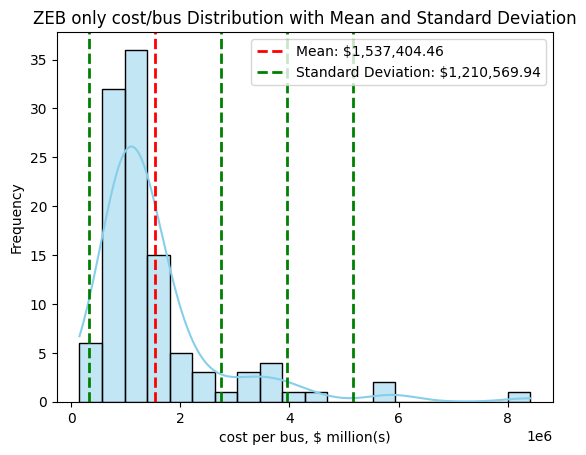

In [7]:
# ZEB only, cpb distribution
print(
    """
ZEB only cost/bus Distribution Chart. 
The majority of the distribution is within +/-1 standard deviation of the mean, however the standard deviation is quite wide at ~$800,000."""
)
dist_curve(
    df = zeb_no_outliers,
    mean = zeb_only_mean,
    std = zeb_only_std,
    title = "ZEB only cost/bus Distribution",
    xlabel = "cost per bus, $ million(s)",
)


non-ZEB only cost/bus Distribution. This distrubtion is is much more spread out and with a smaller standard deviation.


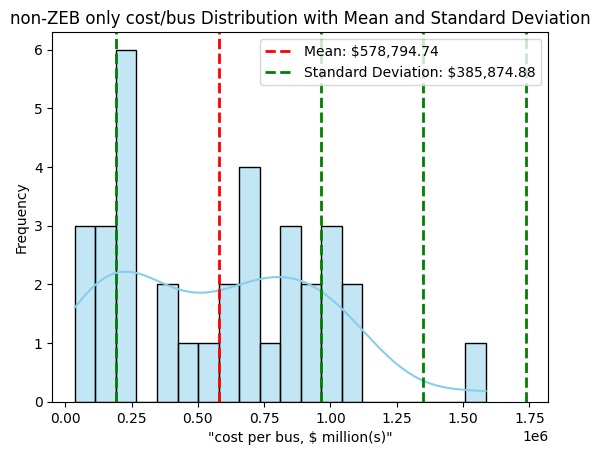

In [8]:
# non_zeb distribution
print(
    """
non-ZEB only cost/bus Distribution. This distrubtion is is much more spread out and with a smaller standard deviation."""
)
dist_curve(
    non_zeb_no_outliers,
    non_zeb_only_mean,
    non_zeb_only_std,
    title="non-ZEB only cost/bus Distribution",
    xlabel='"cost per bus, $ million(s)"',
)


Most funds Awarded by Transit Agency. LA Metro was awarded almost double the next agency.


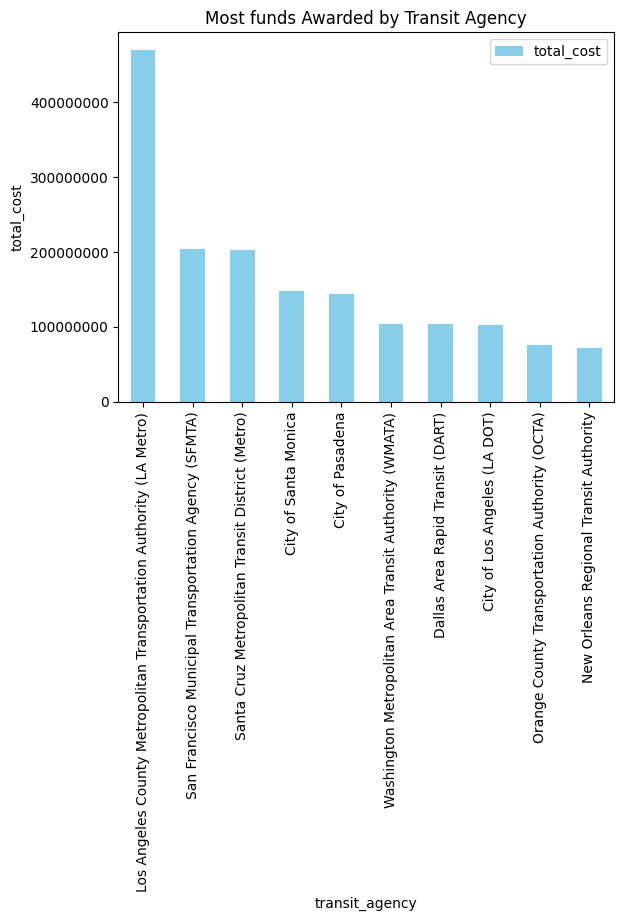

In [9]:
# Higest awarded funds by agency
print(
    """
Most funds Awarded by Transit Agency. LA Metro was awarded almost double the next agency."""
)
make_chart("total_cost", "Most funds Awarded by Transit Agency", data=cpb_zscore, x_col="transit_agency")


Highest Bus Count by Agency. LA Metro plans to procure the most buses.


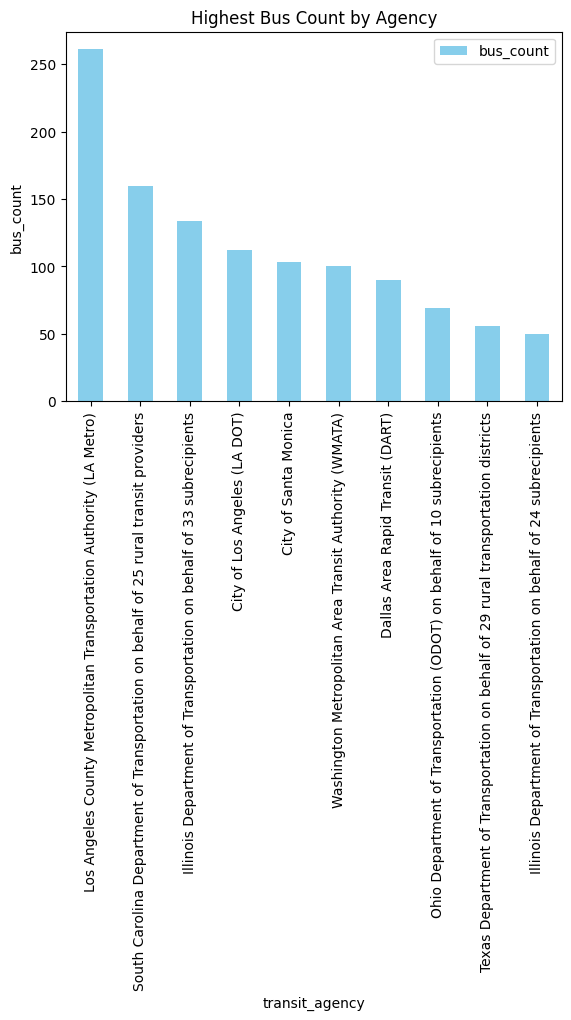

In [10]:
# Highest bus count
print(
    """
Highest Bus Count by Agency. LA Metro plans to procure the most buses."""
)
make_chart("bus_count", "Highest Bus Count by Agency", data=cpb_zscore, x_col="transit_agency")


Cost per bus by propulsion type. the total cost per bus for ZEB categories do fall within a similar range of eachother.


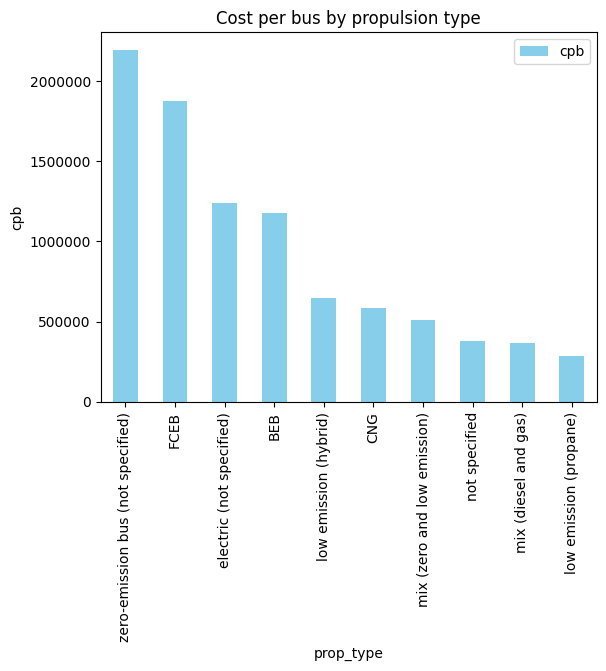

In [11]:
# COST PER BUS BY PROP TYPE
print(
    """
Cost per bus by propulsion type. the total cost per bus for ZEB categories do fall within a similar range of eachother."""
)
make_chart("cpb", "Cost per bus by propulsion type", x_col="prop_type", data=prop_agg)



Bus count by propulsion type. The most common bus type procured were zero-emissions related.



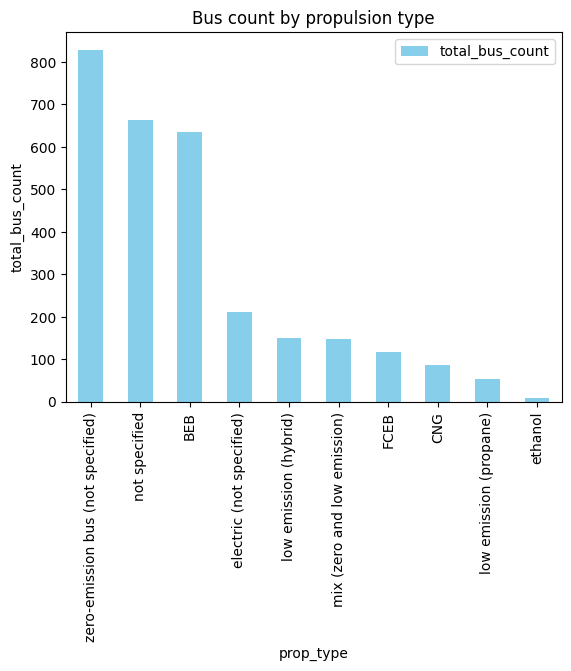

In [12]:
# bus count BY PROP TYPE
print(
    """
Bus count by propulsion type. The most common bus type procured were zero-emissions related.
"""
)
make_chart(
    "total_bus_count", "Bus count by propulsion type", x_col="prop_type", data=prop_agg
)

In [13]:
print(conclusion)


Based on the findings so far, there is data to  supports that bus procurement cost vary widely amongst transit agencies all over the country. 
More so with non-ZEB buses than ZEB buses. Upon reading deeper into the data, it appears transit agencies are still in the early stages of adopting ZEB and capital improvement (building improvement, initial charging infrastructure installation) are needed at this time. 
Cost per bus is suspected to normalize once infrastructure changes are no longer included in projects, and bus only purchases remain. 

